In [1]:
import tensorflow as tf
import tensorflow_io as tfio
#import tensorflow_hub as hub
import numpy as np
import csv
import io
import librosa
import matplotlib.pyplot as plt
import IPython.display as display
from IPython.display import Audio
from scipy.io import wavfile
import PIL.Image

In [2]:
# Modified from tutorial: https://www.tensorflow.org/tutorials/generative/style_transfer

In [3]:
# https://stackoverflow.com/questions/56719138/how-can-i-save-a-librosa-spectrogram-plot-as-a-specific-sized-image
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

def preprocess(mels):
    img = scale_minmax(mels, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0) # put low frequencies at the bottom in image
    img = 255-img # invert. make black==more energy
    return img

In [4]:
def preprocess_spectrogram(img_arr):
    img = preprocess(img_arr)
    img3d = img.reshape((img.shape[0], img.shape[1], 1))
    img3d = np.tile(img3d, 3)
    return img3d

In [5]:
import tensorflow as tf
import tensorflow_io as tfio

def preprocess_img(wav_file_name):
    """Convert wav audio file into an image for input into VGG"""
    audio = tfio.audio.AudioIOTensor(wav_file_name)
    audio_slice = audio[0:]
    audio_tensor = tf.squeeze(audio_slice, axis=[-1])
    tensor = tf.cast(audio_tensor, tf.float32) / 32768.0

    # filter out noise
    position = tfio.experimental.audio.trim(tensor, axis=0, epsilon=0.1)
    start = position[0]
    stop = position[1]
    processed = tensor
    spectrogram = tfio.experimental.audio.spectrogram(
    processed, nfft=512, window=512, stride=256)
    mel_spectrogram = tfio.experimental.audio.melscale(
        spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)
    # Convert to db scale mel-spectrogram
#     dbscale_mel_spectrogram = tfio.experimental.audio.dbscale(
#         mel_spectrogram, top_db=80)
    img_arr = tf.math.log(mel_spectrogram + 1e-9).numpy()
    img = preprocess(img_arr)
    img3d = img.reshape((img.shape[0], img.shape[1], 1))
    img3d = np.tile(img3d, 3)
    return img3d

In [6]:
def load_img(path_to_img):
    """Preprocessing for VGG"""
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    print(img.shape)
    img = tf.image.convert_image_dtype(img, tf.float32)
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    print(shape)
    long_dim = max(shape)
    print(long_dim)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    print(shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
        plt.imshow(image)
    if title:
        plt.title(title)

In [7]:
import pandas as pd
df_test_metadata = pd.read_csv('test_vox1_metadata.csv')

In [8]:
df_test_metadata

,Unnamed: 0,VoxCeleb1 ID,VGGFace1 ID,Gender,Nationality,Set,full_paths
0,269,id10270,Eartha_Kitt,f,USA,test,./data/spmel_test/id10270/x6uYqmx31kE_00002.npy
1,270,id10271,Ed_Westwick,m,UK,test,./data/spmel_test/id10271/zWyD72sHVwA_00001.npy
2,271,id10272,Eddie_Griffin,m,USA,test,./data/spmel_test/id10272/wb6ligRbbZ4_00001.npy
3,272,id10273,Eddie_Izzard,m,UK,test,./data/spmel_test/id10273/xN2fSTQHHkw_00002.npy
4,273,id10274,Eddie_Kaye_Thomas,m,USA,test,./data/spmel_test/id10274/xbGp2KSUr0E_00001.npy
5,274,id10275,Eddie_McClintock,m,USA,test,./data/spmel_test/id10275/mWZ3l5OoyVI_00002.npy
6,275,id10276,Edgar_Wright,m,UK,test,./data/spmel_test/id10276/3vWez3baO60_00002.npy
7,276,id10277,Eduardo_Noriega,m,Spain,test,./data/spmel_test/id10277/cELY3LdIo-0_00003.npy
8,277,id10278,Edward_Asner,m,USA,test,./data/spmel_test/id10278/y990f6UiEEM_00001.npy
9,278,id10279,Efren_Ramirez,m,USA,test,./data/spmel_test/id10279/4Q1IvdayPR8_00014.npy


In [9]:
images = {}
for row in df_test_metadata.iterrows():
    row_item = row[1]
    print(row_item['VoxCeleb1 ID'])
    images[row_item['VoxCeleb1 ID']] = preprocess_spectrogram(np.load(row_item['full_paths']))

id10270
id10271
id10272
id10273
id10274
id10275
id10276
id10277
id10278
id10279
id10280
id10281
id10282
id10283
id10284
id10285
id10286
id10287
id10288
id10289
id10290
id10291
id10292
id10293
id10294
id10295
id10296
id10297
id10298
id10299
id10300
id10301
id10302
id10303
id10304
id10305
id10306
id10307
id10308
id10309


In [10]:
import itertools
image_combinations = list(map(dict, itertools.combinations(
    images.items(), 2)))

(306, 128, 3)
tf.Tensor([306. 128.], shape=(2,), dtype=float32)
tf.Tensor(306.0, shape=(), dtype=float32)
tf.Tensor([306. 128.], shape=(2,), dtype=float32)
(578, 128, 3)
tf.Tensor([578. 128.], shape=(2,), dtype=float32)
tf.Tensor(578.0, shape=(), dtype=float32)
tf.Tensor([578. 128.], shape=(2,), dtype=float32)
Content Image shape (1, 512, 214, 3)


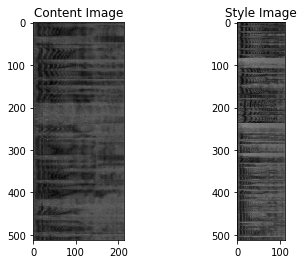

In [13]:
# audio clip from Neil DeGras Tyson
plt.imsave('ndgtyson.png', preprocess_img('/Users/niralshah/Documents/vc-gan/ndgtyson.wav'))
content_path = 'ndgtyson.png'
# audio clip of Niki Minaj
plt.imsave('nkminaj.png', preprocess_img('/Users/niralshah/Documents/vc-gan/nkminaj.wav'))
style_path = 'nkminaj.png'

content_image = load_img(content_path)
style_image = load_img(style_path)
print('Content Image shape', content_image.shape)
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [11]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
print()
for layer in vgg.layers:
    print(layer.name)
prediction_probabilities = vgg(x)
prediction_probabilities.shape


input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
flatten
fc1
fc2
predictions


TensorShape([1, 1000])

In [12]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
print()
for layer in vgg.layers:
    print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [13]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

In [14]:
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [15]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    #get activations from layers we're interested in
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [16]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

block1_conv1
  shape:  (1, 512, 113, 64)
  min:  0.0
  max:  744.50146
  mean:  15.661248

block2_conv1
  shape:  (1, 256, 56, 128)
  min:  0.0
  max:  2238.2803
  mean:  96.22319

block3_conv1
  shape:  (1, 128, 28, 256)
  min:  0.0
  max:  6368.794
  mean:  91.98255

block4_conv1
  shape:  (1, 64, 14, 512)
  min:  0.0
  max:  13762.76
  mean:  381.31085

block5_conv1
  shape:  (1, 32, 7, 512)
  min:  0.0
  max:  1170.607
  mean:  30.748999



In [17]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [18]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers+content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False 
        
    def call(self, inputs):
        """Expects float input in [0,1]"""
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        content_dict = {content_name:value for content_name,value in zip(self.content_layers, content_outputs)}
        style_dict = {
            style_name:value 
            for style_name, value
            in zip(self.style_layers, style_outputs)
        }
        return {'content': content_dict, 'style': style_dict}

In [19]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0
    max:  21525.064
    mean:  311.09857

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  82326.01
    mean:  8548.877

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  702742.2
    mean:  8672.007

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  7238874.5
    mean:  149121.62

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  120942.58
    mean:  802.06116

Contents:
   block5_conv2
    shape:  (1, 32, 13, 512)
    min:  0.0
    max:  994.98737
    mean:  8.791932


In [20]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [21]:
image = tf.Variable(content_image)

In [22]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [23]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight=1e-2
content_weight=1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) for name in style_outputs.keys()])
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [24]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [ ]:
def tensor_to_audio(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    tensor = tf.reduce_mean(tensor,axis=-1)
    audio_arr = librosa.feature.inverse.mel_to_audio(tensor.numpy().astype(np.float64), sr=16000, n_fft=512, hop_length=256, win_length=512, n_iter=64)
    print(audio_arr)
    return audio_arr

In [67]:
train_step(image)
train_step(image)
tensor_to_image(image)
Audio(tensor_to_audio(image), rate=16000)

/Users/niralshah/anaconda/envs/py36/lib/python3.6/site-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


[ 6.1473083   0.8860121  -1.06032    ...  0.72524035 -0.6844712
 -5.8996124 ]


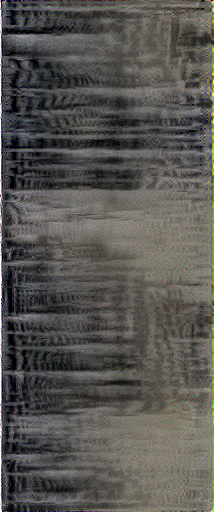

[-3.650859   -1.3562458   0.37244627 ...  3.7281547   0.59652466
 -5.7384415 ]


Train step: 1000
Total time: 1552.6


In [72]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    display.display(Audio(tensor_to_audio(image), rate=16000))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))